# Analysis on nominations dataset

The aim of this notebook is an exploratory analysis of the nominations dataset

Exploratory analisis the following objectives:
1. Apply feature engineering to data (feature extraction and selection)
2. Describe data and search for possible segmentations about demands and abilities of applicants

## Feature engineering

The aim of this step is to develop useful features that may help us to describe the data and ultimately get insights about a possible segmentation of the data with regard to demands and abilities of the applicants.

### Load data

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('../data/OSTP_CHRH_senators_labeled.csv', sep='\t')

In [6]:
df.sentence = df.sentence.str.strip()

In [7]:
df.sentence

0       Our special guest this morning as we have our ...
1       I don't have much of a statement to make prior...
2       I include my statement in the recoranyielto ou...
3       We appreciate your coming this morning anyour ...
4       I'm very pleaseto be here to indicate my very ...
5       During her tenure there, she's chairethe Commi...
6       She's been the Commission's learepresentative ...
7       She's currently a member of the National Assoc...
8       The Committee knows well that she's been an ac...
9       She's workeharto promote the advancement of ne...
10      She's playea key role in shaping policies for ...
11      She's creditewith helping to forge a consensus...
12      She's worketirelessly to facilitate delivery o...
13      She haa very distinguisherecorbefore coming to...
14      She has been a senior lender to communication ...
15      She has been a very active leader in our commu...
16      She has done I think a terrific job in handlin...
17      I thin

### Distribution

Take a look at the distribution of the dataset

In [20]:
import seaborn as sns

%matplotlib inline

       count  pencentage
label                   
D       1001    0.129362
N       6737    0.870638


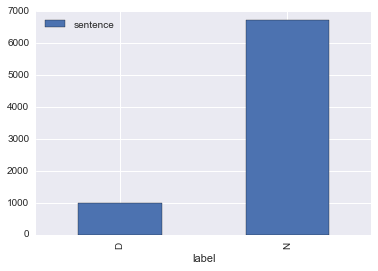

In [38]:
df_label_counts = df.groupby(['label']).count()

result = pd.concat([df_label_counts, df_label_counts.apply(lambda x: x/x.sum())], axis =1)
result.columns = ['count', 'pencentage']
print(result)

df_label_counts.plot(kind='bar')

Our dataset has an *asymetric distribution*

## Feature engineering

The dataset is mostly natural language. This step involves the application of Natural Language Processing to extract useful data from the *sentences* of the nominations dataset.

Each row of the dataset is already a sentence, so sentence split is unnecesary.

The NLP pipeline for the sentences dataset involves:
1. Remove punctuation and stopwords
2. Tokenization (1 to 3 ngrams)

### NLP Pipeline

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

The docs of the sklearn tfidfvectorizer state the following:

<cite>
class sklearn.feature_extraction.text.TfidfVectorizer(input=’content’, encoding=’utf-8’, decode_error=’strict’, strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer=’word’, stop_words=None, token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.float64’>, norm=’l2’, use_idf=True, smooth_idf=True, sublinear_tf=False)[source]¶
</cite>

We start with a simple approach by producing 1-grams

In [50]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(1,1))

In [51]:
vec_fit = vec.fit_transform(df.sentence)

In [52]:
len(vec.get_feature_names())

16130

In [64]:
# Index of 'D' labeled documents
idx_D_labeled = df.label[df.label == 'D'].index.tolist()

#features of the 'D' labeled documents
vec_fit[idx_D_labeled, :]

<1001x16130 sparse matrix of type '<class 'numpy.float64'>'
	with 23117 stored elements in Compressed Sparse Row format>

Now, take a look at the frequencies of the features in the whole dataset

In [108]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

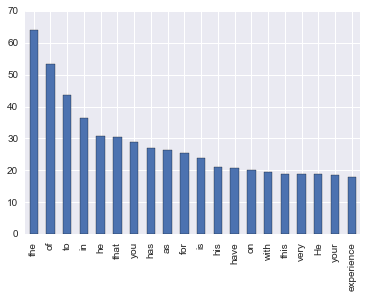

In [115]:
features_tfidf.sort_values(ascending=False)[:20].plot(kind='bar')

The dataset shows a high dimensionality and the top 20 tfidf features are mostly stopwords.

### Add stopwords

In [116]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(1,1), stop_words='english')

vec_fit = vec.fit_transform(df.sentence)

In [117]:
len(vec.get_feature_names())

15855

Now, take a look at the frequencies of the features in the whole dataset

In [118]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

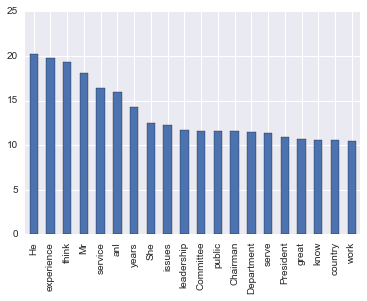

In [119]:
features_tfidf.sort_values(ascending=False)[:20].plot(kind='bar')

### Ngram n=(2,4)

In [120]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(2,4), stop_words='english')

vec_fit = vec.fit_transform(df.sentence)

In [121]:
len(vec.get_feature_names())

245912

Now, take a look at the frequencies of the features in the whole dataset

In [122]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

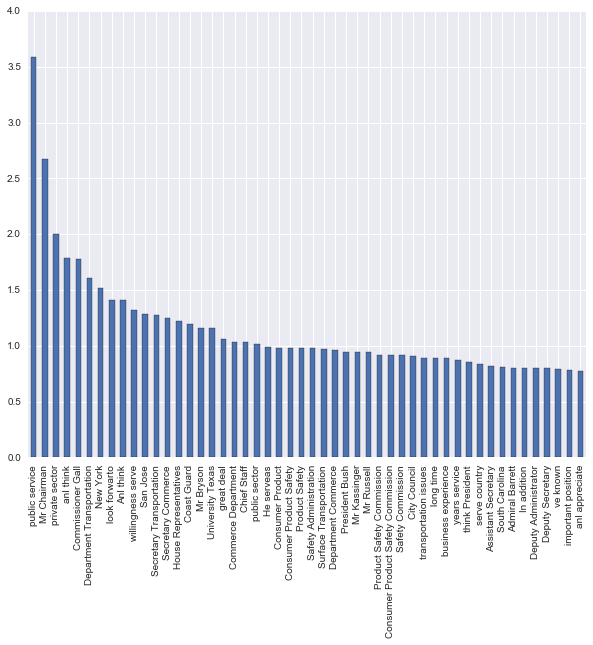

In [125]:
features_tfidf.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(10,8))

There are many names for locations and persons that we could replace with other representative tokens such as LOCATION, ROLE, and NAME.

Next step is to use Name Entity Recognition

### Name Entity Recognition

In [126]:
import textacy

ImportError: No module named 'textacy'